#### Installing packages

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans #Do K-Means clustering
from sklearn.metrics import silhouette_score #Calculate score of silhouette for each K
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator #Find the knee of the WCSS vs K plot
from yellowbrick.cluster import silhouette_visualizer #Plot Silhouette plot
from scipy.stats import f_oneway
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from decimal import Decimal
from prince import FAMD
from kmodes.kprototypes import KPrototypes
import warnings
warnings.filterwarnings('ignore')
random_state = 42

# Reading in dataset

In [3]:
data_combined = pd.read_csv("outlier_removed.csv")
data_combined.head()

,Ship type,Reporting Period,Technical efficiency,tech_eff_name,tech_eff,Port of Registry,Home Port,Total fuel consumption [m tonnes],Total CO₂ emissions [m tonnes],CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes],...,CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes],CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes],Annual Total time spent at sea [hours],Annual average Fuel consumption per distance [kg / n mile],Annual average Fuel consumption per transport work (mass) [g / m tonnes · n miles],Annual average CO₂ emissions per distance [kg CO₂ / n mile],Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles],C02 emissions per hour,C02 emissions per fuel consumption,EEOI_Index
0,Bulk carrier,2018,EIV (4.61 gCO₂/t·nm),EIV,4.61,Nassau,NaN,742.80,2322.60,0.00,...,1349.11,45.85,892.25,89.86,2.45,280.97,7.66,2.603082,3.126817,7.66
1,Bulk carrier,2018,EIV (5.25 gCO₂/t·nm),EIV,5.25,Nassau,NaN,1578.00,4938.31,138.35,...,3205.21,145.55,1243.00,113.57,2.19,355.42,6.85,3.972896,3.129474,6.85
2,Bulk carrier,2018,EIV (7.18 gCO₂/t·nm),EIV,7.18,Monrovia,Monrovia,774.28,2419.56,68.87,...,808.57,241.84,941.44,91.75,4.61,286.71,14.41,2.570063,3.124916,14.41
3,Bulk carrier,2018,EIV (5.2 gCO₂/t·nm),EIV,5.20,Monrovia,NaN,2408.00,7522.34,6940.43,...,0.00,581.91,4106.00,105.15,4.52,328.47,14.12,1.832036,3.123895,14.12
4,Bulk carrier,2018,EIV (7.48 gCO₂/t·nm),EIV,7.48,Monrovia,NaN,5512.40,17234.26,0.00,...,9528.11,259.69,7023.49,67.80,3.60,211.98,11.25,2.453803,3.126453,11.25


In [4]:
data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18777 entries, 0 to 18776
Data columns (total 21 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   Ship type                                                                                    18777 non-null  object 
 1   Reporting Period                                                                             18777 non-null  int64  
 2   Technical efficiency                                                                         18777 non-null  object 
 3   tech_eff_name                                                                                18764 non-null  object 
 4   tech_eff                                                                                     18777 non-null  float64
 5   Port of Registry                

In [5]:
data_combined.columns.to_list()

['Ship type',
 'Reporting Period',
 'Technical efficiency',
 'tech_eff_name',
 'tech_eff',
 'Port of Registry',
 'Home Port',
 'Total fuel consumption [m tonnes]',
 'Total CO₂ emissions [m tonnes]',
 'CO₂ emissions from all voyages between ports under a MS jurisdiction [m tonnes]',
 'CO₂ emissions from all voyages which departed from ports under a MS jurisdiction [m tonnes]',
 'CO₂ emissions from all voyages to ports under a MS jurisdiction [m tonnes]',
 'CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]',
 'Annual Total time spent at sea [hours]',
 'Annual average Fuel consumption per distance [kg / n mile]',
 'Annual average Fuel consumption per transport work (mass) [g / m tonnes · n miles]',
 'Annual average CO₂ emissions per distance [kg CO₂ / n mile]',
 'Annual average CO₂ emissions per transport work (mass) [g CO₂ / m tonnes · n miles]',
 'C02 emissions per hour',
 'C02 emissions per fuel consumption',
 'EEOI_Index']

In [6]:
data_combined_new = data_combined[['tech_eff',
                   'C02 emissions per hour', 
                   'EEOI_Index',
                   'Ship type', 'CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]']]

In [7]:
# new dataframe for clustering
columns_to_keep = ['tech_eff',
                   'C02 emissions per hour', 
                   'EEOI_Index',
                   'Ship type']

In [8]:
data = data_combined[columns_to_keep]
data = data.dropna() #drop rows with nan values
data.head()

,tech_eff,C02 emissions per hour,EEOI_Index,Ship type
0,4.61,2.603082,7.66,Bulk carrier
1,5.25,3.972896,6.85,Bulk carrier
2,7.18,2.570063,14.41,Bulk carrier
3,5.20,1.832036,14.12,Bulk carrier
4,7.48,2.453803,11.25,Bulk carrier


In [9]:
data.describe()

,tech_eff,C02 emissions per hour,EEOI_Index
count,18777.000000,18777.000000,18777.000000
mean,9.876830,4.155114,33.346971
std,7.093782,2.763931,96.263418
min,2.870000,0.857816,3.560000
25%,4.630000,2.581823,8.440000
50%,6.680000,3.327522,12.750000
75%,14.000000,4.595558,23.690000
max,65.760000,21.353963,2038.890000


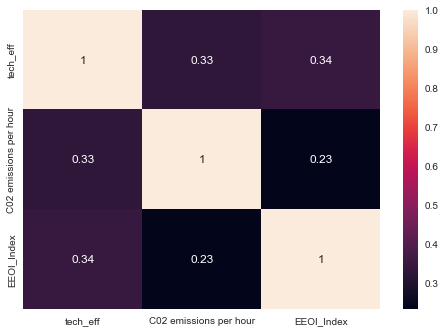

In [10]:
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [11]:
data_kmeans = data.iloc[:,:-1].to_numpy()
scaler = StandardScaler()
data_kmeans = scaler.fit_transform(data_kmeans) #Scaling inputs if required

In [12]:
np.shape(data_kmeans)

(18777, 3)

In [13]:
data_kmeans_df = pd.DataFrame(data_kmeans)
data_kmeans_df.columns = columns_to_keep[:-1]
data_kmeans_df.head()

,tech_eff,C02 emissions per hour,EEOI_Index
0,-0.742477,-0.561545,-0.266848
1,-0.652255,-0.065929,-0.275262
2,-0.380178,-0.573492,-0.196726
3,-0.659303,-0.840520,-0.199738
4,-0.337887,-0.615557,-0.229553


# Choosing appropriate number of clusters

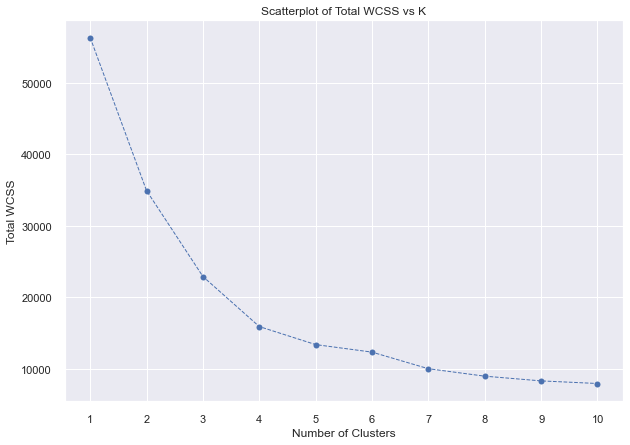

In [14]:
wcss = []
max_k = 10 
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_kmeans)
    wcss.append(kmeans.inertia_)

sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [15]:
#To locate the elbow point of the curve using kneed package
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

4

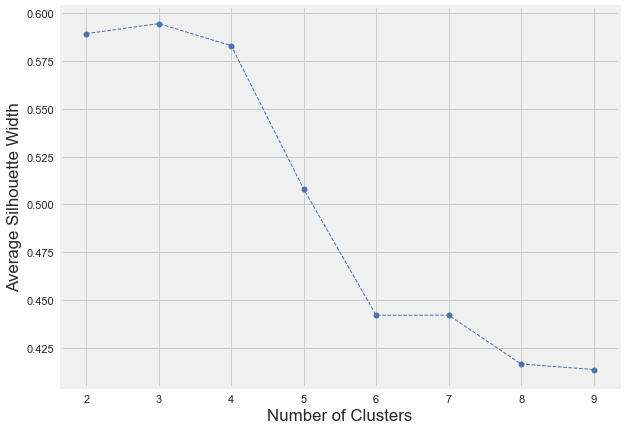

In [16]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_kmeans)
    score = silhouette_score(data_kmeans, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

In [17]:
#silhouette dictionary to track the silhouette scores for different k 
silhouette_dict = {}

#Fit kmeans labels onto our dataframe
#Input: df and int, Output:df 
def kmeans_label(data, num_clusters): 
  kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
  kmeans_model.fit(data.to_numpy())
  data2 = data.copy()
  labels = kmeans_model.labels_
  data2['Clusters'] = pd.DataFrame(labels)
  return data2

In [18]:
#Plot the silhouettes
#Input: df, Output: plt graphs
def plot_silhouettes(data,num_clusters):
  dataarray = data.to_numpy()
  model = KMeans(num_clusters,random_state=42)
  plt.figure(figsize=(10, 7)) 
  sns.set(font_scale = 1)
  silhouette_visualizer(model, dataarray, colors='yellowbrick')
  score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
  if num_clusters not in silhouette_dict.keys():
    silhouette_dict[num_clusters] = score
  print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))

## KMeans with 2 Clusters

In [19]:
kmeans2 = KMeans(init="random",n_clusters =2 , random_state = 42)
kmeans2.fit(data_kmeans)
clustergroups2 = kmeans2.labels_ #The cluster number for each row

In [20]:
Clustercenters2 = pd.DataFrame(kmeans2.cluster_centers_) #Dataframe of cluster centers
Clustercenters2.rename(columns={0: "Tech eff", 1: "CO2 per hour", 2: "EEOI_Index"},inplace=True)
Clustercenters2.index.name = "Clusters"

In [21]:
Clustercenters2

,Tech eff,CO2 per hour,EEOI_Index
Clusters,,,
0,1.334024,1.177189,0.581276
1,-0.434472,-0.383393,-0.189313


In [22]:
#Inertia actually calculates the sum of distances of all the points within a cluster from the
#centroid of that cluster, and sum it against all clusters.

print(kmeans2.inertia_)
print('%.1E' % Decimal(kmeans2.inertia_))

34907.07544713351
3.5E+04


In [23]:
model2 = kmeans_label(data_kmeans_df, 2) #Attach kmeans_labels to our data
model2.head() # which cluster each row belongs to

,tech_eff,C02 emissions per hour,EEOI_Index,Clusters
0,-0.742477,-0.561545,-0.266848,1
1,-0.652255,-0.065929,-0.275262,1
2,-0.380178,-0.573492,-0.196726,1
3,-0.659303,-0.840520,-0.199738,1
4,-0.337887,-0.615557,-0.229553,1


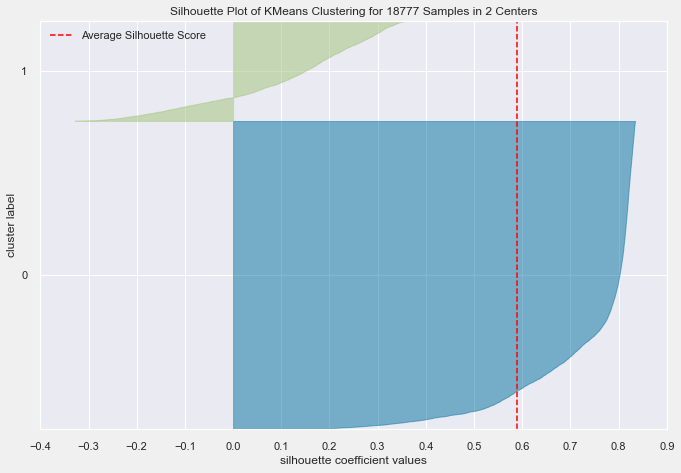

For n_clusters = 2 The average silhouette_score is: 0.5892463592100109 


In [24]:
plot_silhouettes(data_kmeans_df, 2)

In [25]:
pd.DataFrame(model2.groupby('Clusters').Clusters.count())

,Clusters
Clusters,
0,4609
1,14168


In [26]:
data = data.reset_index()
final = pd.concat([data, model2['Clusters']], axis=1)
final = final.iloc[:,1:]
final.head()

,tech_eff,C02 emissions per hour,EEOI_Index,Ship type,Clusters
0,4.61,2.603082,7.66,Bulk carrier,1
1,5.25,3.972896,6.85,Bulk carrier,1
2,7.18,2.570063,14.41,Bulk carrier,1
3,5.20,1.832036,14.12,Bulk carrier,1
4,7.48,2.453803,11.25,Bulk carrier,1


In [27]:
# Investigating Co2 emissions at berth

data_combined_new = pd.concat([data_combined_new, model2['Clusters']], axis = 1)
data_combined_new.groupby('Clusters').mean()['CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]'].to_frame()

,CO₂ emissions which occurred within ports under a MS jurisdiction at berth [m tonnes]
Clusters,
0,1221.667804
1,536.174514


In [28]:
# We see that ships in cluster 0 have worse emissions as compared to those in cluster 1
final.groupby('Clusters').mean()

,tech_eff,C02 emissions per hour,EEOI_Index
Clusters,,,
0,19.341627,7.412251,89.329577
1,6.797832,3.095533,15.135239


In [29]:
# compute percentage of each ship in each cluster
df = final.reset_index().groupby(['Clusters', 'Ship type']).size().to_frame('count')
df['percentage'] = df['count'].div(df.groupby('Ship type')['count'].transform('sum')).mul(100)
df

count  percentage
Clusters Ship type                                    
0        Combination carrier             3   23.076923
         Container ship               2768   92.917086
         Container/ro-ro cargo ship      2   50.000000
         Gas carrier                    56   11.618257
         General cargo ship             19    1.153613
         LNG carrier                     1   50.000000
         Other ship types               52   46.846847
         Passenger ship                122  100.000000
         Refrigerated cargo carrier    193   90.186916
         Ro-pax ship                   486   92.748092
         Ro-ro ship                    262   75.287356
         Vehicle carrier               645   94.574780
1        Bulk carrier                 6108  100.000000
         Chemical tanker              2111  100.000000
         Combination carrier            10   76.923077
         Container ship                211    7.082914
         Container/ro-ro cargo ship      2   50.000000
         Gas carrier                   426   88.381743
         General cargo ship           1628   98.846387
         LNG carrier                     1   50.000000
         Oil tanker                   3430  100.000000
         Other ship types               59   53.153153
         Refrigerated cargo carrier     21    9.813084
         Ro-pax ship                    38    7.251908
         Ro-ro ship                     86   24.712644
         Vehicle carrier                37    5.425220

In [30]:
# majority of ships in each cluster
df[df['percentage'] > 90]

count  percentage
Clusters Ship type                                    
0        Container ship               2768   92.917086
         Passenger ship                122  100.000000
         Refrigerated cargo carrier    193   90.186916
         Ro-pax ship                   486   92.748092
         Vehicle carrier               645   94.574780
1        Bulk carrier                 6108  100.000000
         Chemical tanker              2111  100.000000
         General cargo ship           1628   98.846387
         Oil tanker                   3430  100.000000

### Kmeans with 3 clusters

In [31]:
kmeans3 = KMeans(init="random",n_clusters =3 , random_state = 42)
kmeans3.fit(data_kmeans)
clustergroups3 = kmeans3.labels_ #The cluster number for each row

In [32]:
Clustercenters3 = pd.DataFrame(kmeans3.cluster_centers_) #Dataframe of cluster centers
Clustercenters3.rename(columns={0: "Tech eff", 1: "CO2 per hour", 2: "EEOI_Index"},inplace=True)
Clustercenters3.index.name = "Clusters"

In [33]:
Clustercenters3

,Tech eff,CO2 per hour,EEOI_Index
Clusters,,,
0,1.305942,1.084989,0.154895
1,1.696147,1.960961,6.763704
2,-0.448620,-0.384037,-0.187826


In [34]:
#Inertia actually calculates the sum of distances of all the points within a cluster from the
#centroid of that cluster, and sum it against all clusters.

print(kmeans3.inertia_)
print('%.1E' % Decimal(kmeans3.inertia_))

22896.15587055151
2.3E+04


In [35]:
model3 = kmeans_label(data_kmeans_df, 3) #Attach kmeans_labels to our data
model3.head() # which cluster each row belongs to

,tech_eff,C02 emissions per hour,EEOI_Index,Clusters
0,-0.742477,-0.561545,-0.266848,2
1,-0.652255,-0.065929,-0.275262,2
2,-0.380178,-0.573492,-0.196726,2
3,-0.659303,-0.840520,-0.199738,2
4,-0.337887,-0.615557,-0.229553,2


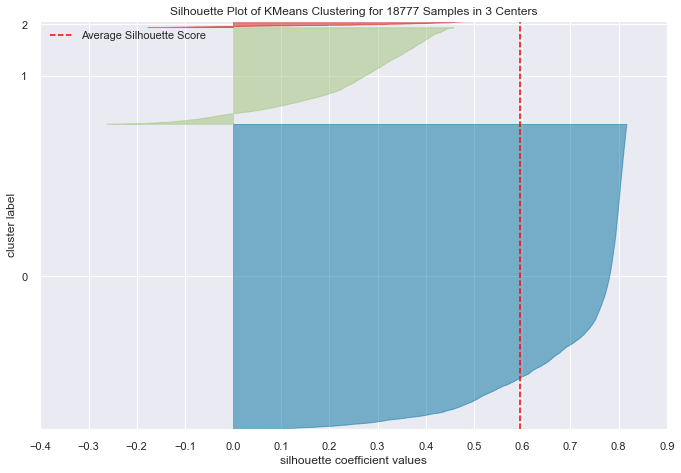

For n_clusters = 3 The average silhouette_score is: 0.5944802437741223 


In [36]:
plot_silhouettes(data_kmeans_df, 3)

In [37]:
pd.DataFrame(model3.groupby('Clusters').Clusters.count())

,Clusters
Clusters,
0,4449
1,288
2,14040


In [38]:
final1 = pd.concat([data, model3['Clusters']], axis=1)
final1 = final1.iloc[:,1:]
final1.head()

,tech_eff,C02 emissions per hour,EEOI_Index,Ship type,Clusters
0,4.61,2.603082,7.66,Bulk carrier,2
1,5.25,3.972896,6.85,Bulk carrier,2
2,7.18,2.570063,14.41,Bulk carrier,2
3,5.20,1.832036,14.12,Bulk carrier,2
4,7.48,2.453803,11.25,Bulk carrier,2


In [39]:
final1.groupby('Clusters').mean()

,tech_eff,C02 emissions per hour,EEOI_Index
Clusters,,,
0,19.140652,7.153869,48.257332
1,21.908611,9.574932,684.426910
2,6.694501,3.093691,15.266685


### Kmeans with 5 clusters 

In [40]:
kmeans5 = KMeans(init="random",n_clusters =5 , random_state = 42)
kmeans5.fit(data_kmeans)
clustergroups5 = kmeans5.labels_ #The cluster number for eac0: "Tech eff", 1: "CO2 per hour", 2: "EEOI_Index"h row

In [41]:
Clustercenters5 = pd.DataFrame(kmeans5.cluster_centers_) #Dataframe of cluster centers
Clustercenters5.rename(columns={0: "Tech eff", 1: "CO2 per hour", 2: "EEOI_Index"},inplace=True)
Clustercenters5.index.name = "Clusters"

In [42]:
Clustercenters5

,Tech eff,CO2 per hour,EEOI_Index
Clusters,,,
0,-0.649912,-0.297851,-0.228036
1,1.635751,0.351925,0.301421
2,0.495680,-0.714651,0.005668
3,1.806594,1.851638,7.581291
4,0.752288,2.713859,0.029963


In [43]:
print(kmeans5.inertia_)
print('%.1E' % Decimal(kmeans5.inertia_))

13368.317038410389
1.3E+04


In [44]:
model5 = kmeans_label(data_kmeans_df, 5) #Attach kmeans_labels to our data
model5.head() # which cluster each row belongs to

,tech_eff,C02 emissions per hour,EEOI_Index,Clusters
0,-0.742477,-0.561545,-0.266848,0
1,-0.652255,-0.065929,-0.275262,0
2,-0.380178,-0.573492,-0.196726,0
3,-0.659303,-0.840520,-0.199738,0
4,-0.337887,-0.615557,-0.229553,0


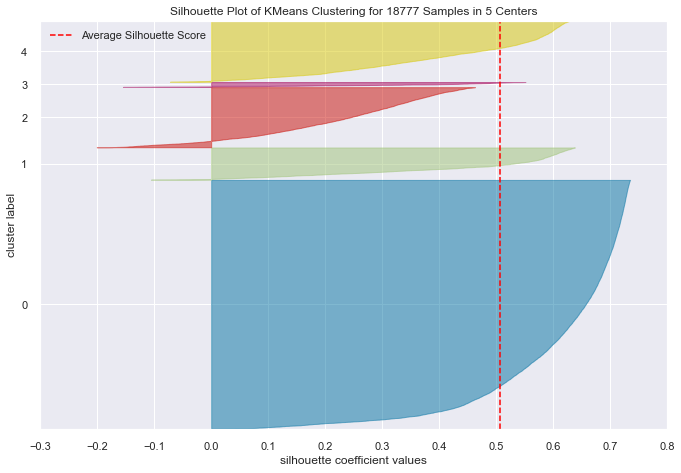

For n_clusters = 5 The average silhouette_score is: 0.5080431664983177 


In [45]:
plot_silhouettes(data_kmeans_df, 5)

In [46]:
pd.DataFrame(model5.groupby('Clusters').Clusters.count())

,Clusters
Clusters,
0,11475
1,2773
2,2815
3,227
4,1487


In [47]:
final3 = pd.concat([data, model5['Clusters']], axis=1)
final3 = final3.iloc[:,1:]
final3.head()

,tech_eff,C02 emissions per hour,EEOI_Index,Ship type,Clusters
0,4.61,2.603082,7.66,Bulk carrier,0
1,5.25,3.972896,6.85,Bulk carrier,0
2,7.18,2.570063,14.41,Bulk carrier,0
3,5.20,1.832036,14.12,Bulk carrier,0
4,7.48,2.453803,11.25,Bulk carrier,0


In [48]:
final3.groupby('Clusters').mean()

,tech_eff,C02 emissions per hour,EEOI_Index
Clusters,,,
0,5.266616,3.331895,11.396053
1,21.477241,5.126836,62.338612
2,13.390131,2.178760,33.895343
3,22.692070,9.272777,763.128546
4,15.213255,11.655834,36.231224


### Kmeans with 4 clusters

In [49]:
kmeans4 = KMeans(init="random",n_clusters =4 , random_state = 42)
kmeans4.fit(data_kmeans)
clustergroups4 = kmeans4.labels_ #The cluster number for each row

In [50]:
Clustercenters4 = pd.DataFrame(kmeans4.cluster_centers_) #Dataframe of cluster centers
Clustercenters4.rename(columns={0: "Tech eff", 1: "CO2 per hour", 2: "EEOI_Index"},inplace=True)
Clustercenters4.index.name = "Clusters"

In [51]:
Clustercenters4

,Tech eff,CO2 per hour,EEOI_Index
Clusters,,,
0,1.288665,-0.121141,0.199039
1,1.807764,1.824098,7.366055
2,-0.572530,-0.341789,-0.213549
3,0.876941,2.537506,0.065706


In [52]:
print(kmeans4.inertia_)
print('%.1E' % Decimal(kmeans4.inertia_))

15891.247701211258
1.6E+04


In [53]:
model4 = kmeans_label(data_kmeans_df, 4) #Attach kmeans_labels to our data
model4.head() # which cluster each row belongs to

,tech_eff,C02 emissions per hour,EEOI_Index,Clusters
0,-0.742477,-0.561545,-0.266848,2
1,-0.652255,-0.065929,-0.275262,2
2,-0.380178,-0.573492,-0.196726,2
3,-0.659303,-0.840520,-0.199738,2
4,-0.337887,-0.615557,-0.229553,2


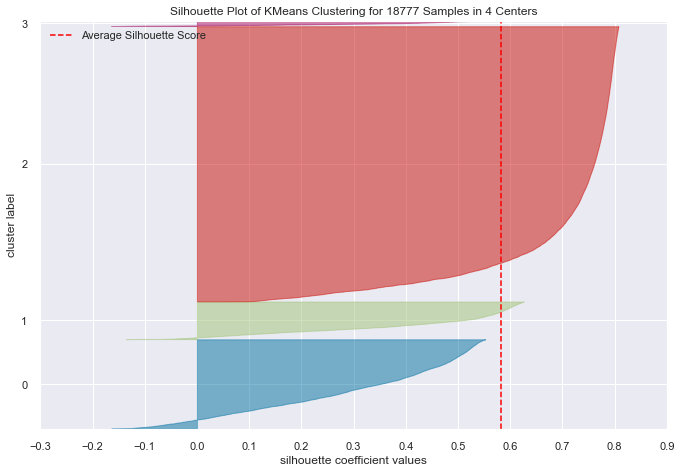

For n_clusters = 4 The average silhouette_score is: 0.5829322699572005 


In [54]:
plot_silhouettes(data_kmeans_df, 4)

In [55]:
pd.DataFrame(model4.groupby('Clusters').Clusters.count())

,Clusters
Clusters,
0,4117
1,241
2,12687
3,1732


In [56]:
final2 = pd.concat([data, model4['Clusters']], axis=1)
final2 = final2.iloc[:,1:]
final2

,tech_eff,C02 emissions per hour,EEOI_Index,Ship type,Clusters
0,4.61,2.603082,7.66,Bulk carrier,2
1,5.25,3.972896,6.85,Bulk carrier,2
2,7.18,2.570063,14.41,Bulk carrier,2
3,5.20,1.832036,14.12,Bulk carrier,2
4,7.48,2.453803,11.25,Bulk carrier,2
...,...,...,...,...,...
18772,20.15,5.259003,62.32,Vehicle carrier,0
18773,16.62,4.759130,52.48,Vehicle carrier,0
18774,16.61,5.140443,59.95,Vehicle carrier,0
18775,16.52,4.616398,59.71,Vehicle carrier,0


In [57]:
final2.groupby('Clusters').mean()

,tech_eff,C02 emissions per hour,EEOI_Index
Clusters,,,
0,19.020942,3.821298,52.522686
1,22.700373,9.196661,742.409751
2,5.816692,3.210230,12.791651
3,16.097494,11.168421,39.671917


## Scoring System

In [58]:
columns_to_keep = ['Ship type',
                   'tech_eff',
                   'C02 emissions per hour', 
                   'EEOI_Index']
                   
data = data_combined[columns_to_keep]
data = data.dropna() #drop rows with nan values
data.head()

,Ship type,tech_eff,C02 emissions per hour,EEOI_Index
0,Bulk carrier,4.61,2.603082,7.66
1,Bulk carrier,5.25,3.972896,6.85
2,Bulk carrier,7.18,2.570063,14.41
3,Bulk carrier,5.20,1.832036,14.12
4,Bulk carrier,7.48,2.453803,11.25


In [59]:
ships = data['Ship type'].unique()
ships

array(['Bulk carrier', 'Chemical tanker', 'Combination carrier',
       'Container ship', 'Container/ro-ro cargo ship', 'Gas carrier',
       'General cargo ship', 'LNG carrier', 'Oil tanker',
       'Other ship types', 'Passenger ship', 'Refrigerated cargo carrier',
       'Ro-pax ship', 'Ro-ro ship', 'Vehicle carrier'], dtype=object)

In [60]:
data.groupby('Ship type').tech_eff.count()

Ship type
Bulk carrier                  6108
Chemical tanker               2111
Combination carrier             13
Container ship                2979
Container/ro-ro cargo ship       4
Gas carrier                    482
General cargo ship            1647
LNG carrier                      2
Oil tanker                    3430
Other ship types               111
Passenger ship                 122
Refrigerated cargo carrier     214
Ro-pax ship                    524
Ro-ro ship                     348
Vehicle carrier                682
Name: tech_eff, dtype: int64

In [61]:
### Focusing on Passenger ship, Bulk carrier, Ro-pax ship
data.groupby(['Ship type']).agg(tech_eff_mean = ('tech_eff', 'mean'), co2_mean = ('C02 emissions per hour', 'mean'), 
                                EEOI_mean = ('EEOI_Index', 'mean')).loc[['Bulk carrier', 'Passenger ship', 'Ro-pax ship']]

,tech_eff_mean,co2_mean,EEOI_mean
Ship type,,,
Bulk carrier,5.063194,2.908431,8.726194
Passenger ship,16.425902,11.287925,709.648115
Ro-pax ship,23.267767,8.440902,314.403073


In [62]:
# create new column 'tech_eff_score'
final1 = pd.DataFrame()
data['tech_eff_score'] = np.nan
p = [0.33, 0.67] 
for s in ships:
    dat = data[data['Ship type'] == s].reset_index().iloc[:,1:]
    for i in range(0, len(dat)):
        if dat['tech_eff'][i] <= np.percentile(dat['tech_eff'], p[0]*100):
            dat['tech_eff_score'][i] = 1 #good
        elif dat['tech_eff'][i] <= np.percentile(dat['tech_eff'], p[1]*100):
            dat['tech_eff_score'][i] = 0 #avg
        else:
            dat['tech_eff_score'][i] = -1 #bad
    final1 = pd.concat([final1, dat])

In [63]:
# create new column 'CO2_score'
final2 = pd.DataFrame()
data['CO2_score'] = np.nan
p = [0.33, 0.67] 
for s in ships:
    dat = data[data['Ship type'] == s].reset_index().iloc[:,1:]
    for i in range(0, len(dat)):
        if dat['C02 emissions per hour'][i] <= np.percentile(dat['C02 emissions per hour'], p[0]*100):
            dat['CO2_score'][i] = 1 #good
        elif dat['C02 emissions per hour'][i] <= np.percentile(dat['C02 emissions per hour'], p[1]*100):
            dat['CO2_score'][i] = 0 #avg
        else:
            dat['CO2_score'][i] = -1 #bad
    final2 = pd.concat([final2, dat])

In [64]:
# create new column 'EEOI_score'
final3 = pd.DataFrame()
data['EEOI_score'] = np.nan
p = [0.33, 0.67] 
for s in ships:
    dat = data[data['Ship type'] == s].reset_index().iloc[:,1:]
    for i in range(0, len(dat)):
        if dat['EEOI_Index'][i] <= np.percentile(dat['EEOI_Index'], p[0]*100):
            dat['EEOI_score'][i] = 1 #good
        elif dat['EEOI_Index'][i] <= np.percentile(dat['EEOI_Index'], p[1]*100):
            dat['EEOI_score'][i] = 0 #avg
        else:
            dat['EEOI_score'][i] = -1 #bad
    final3 = pd.concat([final3, dat])

In [65]:
final1['CO2_score'] = final2['CO2_score']
final1['EEOI_score'] = final3['EEOI_score']

In [66]:
final1.groupby('Ship type').mean()

,tech_eff,C02 emissions per hour,EEOI_Index,tech_eff_score,CO2_score,EEOI_score
Ship type,,,,,,
Bulk carrier,5.063194,2.908431,8.726194,0.000982,0.0,0.001473
Chemical tanker,8.084135,2.829506,18.615486,0.001421,0.0,0.000947
Combination carrier,13.113846,2.783394,59.116923,0.153846,0.0,0.000000
Container ship,18.031883,7.972765,21.797687,0.000671,0.0,0.000000
Container/ro-ro cargo ship,12.135000,5.184627,99.622500,0.250000,0.0,0.000000
Gas carrier,12.089502,3.174200,54.446432,0.000000,0.0,0.000000
General cargo ship,13.362678,1.711292,25.659854,0.001214,0.0,0.000607
LNG carrier,7.335000,8.441376,38.020000,0.000000,0.0,0.000000
Oil tanker,4.664327,4.134405,10.304192,0.004082,0.0,0.000583


In [67]:
final1['Avg_score'] = final1.iloc[:, 4:].mean(axis=1)
final1.head()

,Ship type,tech_eff,C02 emissions per hour,EEOI_Index,tech_eff_score,CO2_score,EEOI_score,Avg_score
0,Bulk carrier,4.61,2.603082,7.66,0.0,0.0,0.0,0.000000
1,Bulk carrier,5.25,3.972896,6.85,0.0,-1.0,1.0,0.000000
2,Bulk carrier,7.18,2.570063,14.41,-1.0,1.0,-1.0,-0.333333
3,Bulk carrier,5.20,1.832036,14.12,0.0,1.0,-1.0,0.000000
4,Bulk carrier,7.48,2.453803,11.25,-1.0,1.0,-1.0,-0.333333


In [68]:
avg_scores = np.sort(final1['Avg_score'].unique())
avg_scores

array([-1.        , -0.66666667, -0.33333333,  0.        ,  0.33333333,
        0.66666667,  1.        ])

In [69]:
final1['Scoring'] = np.nan

In [70]:
# change their scores to [0,6] - the higher the better
for x in range(0, len(avg_scores)):
    for i in range(0, len(final1)):
        dat = final1['Avg_score'].iloc[i]
        if dat == avg_scores[x]:
            final1['Scoring'][i] = x

In [71]:
final1.head()

,Ship type,tech_eff,C02 emissions per hour,EEOI_Index,tech_eff_score,CO2_score,EEOI_score,Avg_score,Scoring
0,Bulk carrier,4.61,2.603082,7.66,0.0,0.0,0.0,0.000000,3.0
1,Bulk carrier,5.25,3.972896,6.85,0.0,-1.0,1.0,0.000000,3.0
2,Bulk carrier,7.18,2.570063,14.41,-1.0,1.0,-1.0,-0.333333,2.0
3,Bulk carrier,5.20,1.832036,14.12,0.0,1.0,-1.0,0.000000,3.0
4,Bulk carrier,7.48,2.453803,11.25,-1.0,1.0,-1.0,-0.333333,2.0


In [72]:
pd.set_option('display.max_rows', None)
final1.groupby(['Ship type', 'Scoring']).tech_eff.count()

Ship type                   Scoring
Bulk carrier                0.0         167
                            1.0         719
                            2.0        1445
                            3.0        1499
                            4.0        1334
                            5.0         767
                            6.0         177
Chemical tanker             0.0          67
                            1.0         263
                            2.0         597
                            3.0         531
                            4.0         392
                            5.0         207
                            6.0          54
Combination carrier         1.0           2
                            2.0           3
                            3.0           5
                            4.0           2
                            5.0           1
Container ship              0.0         100
                            1.0         421
                            2.0         

In [73]:
final1.groupby('Ship type').mean()

,tech_eff,C02 emissions per hour,EEOI_Index,tech_eff_score,CO2_score,EEOI_score,Avg_score,Scoring
Ship type,,,,,,,,
Bulk carrier,5.063194,2.908431,8.726194,0.000982,0.0,0.001473,8.185986e-04,3.002456
Chemical tanker,8.084135,2.829506,18.615486,0.001421,0.0,0.000947,7.895152e-04,2.831360
Combination carrier,13.113846,2.783394,59.116923,0.153846,0.0,0.000000,5.128205e-02,2.769231
Container ship,18.031883,7.972765,21.797687,0.000671,0.0,0.000000,2.237887e-04,2.723397
Container/ro-ro cargo ship,12.135000,5.184627,99.622500,0.250000,0.0,0.000000,8.333333e-02,2.750000
Gas carrier,12.089502,3.174200,54.446432,0.000000,0.0,0.000000,1.151684e-19,2.514523
General cargo ship,13.362678,1.711292,25.659854,0.001214,0.0,0.000607,6.071645e-04,2.789921
LNG carrier,7.335000,8.441376,38.020000,0.000000,0.0,0.000000,0.000000e+00,3.000000
Oil tanker,4.664327,4.134405,10.304192,0.004082,0.0,0.000583,1.554908e-03,2.781341


In [74]:
final1['Comparative_scoring'] = np.nan

In [75]:
for i in range(0, len(final1)):
    dat = final1['Scoring'].iloc[i]
    if dat == 3.0:
        final1['Comparative_scoring'][i] = "average"
    elif dat < 3.0:
        final1['Comparative_scoring'][i] = "below average"
    else:
        final1['Comparative_scoring'][i] = "above average"

In [76]:
final1.head()

,Ship type,tech_eff,C02 emissions per hour,EEOI_Index,tech_eff_score,CO2_score,EEOI_score,Avg_score,Scoring,Comparative_scoring
0,Bulk carrier,4.61,2.603082,7.66,0.0,0.0,0.0,0.000000,3.0,average
1,Bulk carrier,5.25,3.972896,6.85,0.0,-1.0,1.0,0.000000,3.0,average
2,Bulk carrier,7.18,2.570063,14.41,-1.0,1.0,-1.0,-0.333333,2.0,below average
3,Bulk carrier,5.20,1.832036,14.12,0.0,1.0,-1.0,0.000000,3.0,average
4,Bulk carrier,7.48,2.453803,11.25,-1.0,1.0,-1.0,-0.333333,2.0,below average


In [77]:
final1.groupby(['Ship type', 'Comparative_scoring']).tech_eff.mean()

Ship type                   Comparative_scoring
Bulk carrier                above average           4.280255
                            average                 5.042608
                            below average           5.841570
Chemical tanker             above average           8.264303
                            average                 8.051168
                            below average           7.976106
Combination carrier         above average           9.423333
                            average                11.712000
                            below average          16.730000
Container ship              above average          17.358949
                            average                18.182642
                            below average          18.347942
Container/ro-ro cargo ship  average                12.796667
                            below average          10.150000
Gas carrier                 above average          11.889057
                            average  

In [78]:
final1[final1['Ship type'] == 'Passenger ship'].groupby(['Ship type', 'Comparative_scoring']).tech_eff.mean()

Ship type       Comparative_scoring
Passenger ship  above average          17.373200
                average                15.578750
                below average          16.478615
Name: tech_eff, dtype: float64

In [79]:
subset = final1[final1['Ship type'].isin(['Bulk carrier', 'Passenger ship', 'Ro-pax ship'])]
subset = subset[['Ship type', 'Scoring', 'Comparative_scoring']]

In [80]:
subset['Scoring'] = subset['Scoring'].astype(int)
# subset['Scoring'] = subset['Scoring'].astype(object)

In [81]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6754 entries, 0 to 523
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Ship type            6754 non-null   object
 1   Scoring              6754 non-null   int64 
 2   Comparative_scoring  6754 non-null   object
dtypes: int64(1), object(2)
memory usage: 211.1+ KB


In [82]:
# subset.group(['Ship type', 'Scoring'])['Scoring'].count()
subset['Scoring'].value_counts(ascending = False)

2    1663
3    1660
4    1426
1     825
5     803
0     194
6     183
Name: Scoring, dtype: int64

In [83]:
subset.groupby('Ship type')['Scoring'].value_counts(ascending = False)

Ship type       Scoring
Bulk carrier    3          1499
                2          1445
                4          1334
                5           767
                1           719
                6           177
                0           167
Passenger ship  2            43
                3            32
                4            20
                1            17
                0             5
                5             3
                6             2
Ro-pax ship     2           175
                3           129
                1            89
                4            72
                5            33
                0            22
                6             4
Name: Scoring, dtype: int64

In [84]:
subset_df = subset.groupby('Ship type')['Scoring'].value_counts().unstack()
subset_df

Scoring,0,1,2,3,4,5,6
Ship type,,,,,,,
Bulk carrier,167,719,1445,1499,1334,767,177
Passenger ship,5,17,43,32,20,3,2
Ro-pax ship,22,89,175,129,72,33,4


<Figure size 720x360 with 0 Axes>

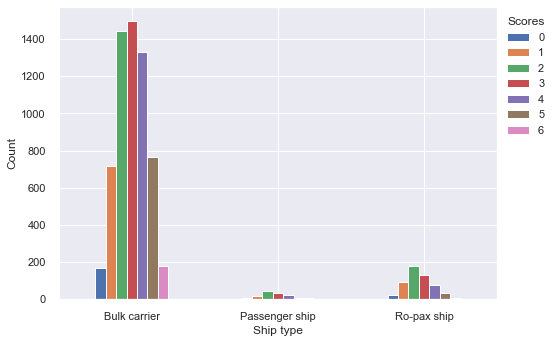

In [85]:
fig = plt.figure(figsize = (10, 5))
# plot
ax = subset_df.plot(kind='bar', figsize=(7, 5), xlabel='Ship type', ylabel='Count', rot = 0)
ax.legend(title='Scores', bbox_to_anchor=(1, 1), loc='upper left')

In [86]:
c_score = subset.groupby('Ship type')['Comparative_scoring'].value_counts().unstack()
c_score

Comparative_scoring,above average,average,below average
Ship type,,,
Bulk carrier,2278,1499,2331
Passenger ship,25,32,65
Ro-pax ship,109,129,286


<Figure size 720x360 with 0 Axes>

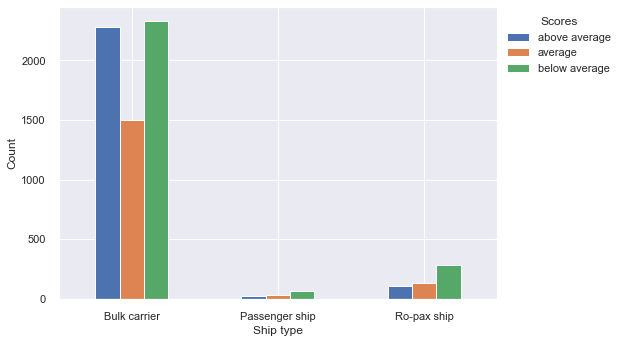

In [87]:
fig = plt.figure(figsize = (10, 5))
# plot
ax = c_score.plot(kind='bar', figsize=(7, 5), xlabel='Ship type', ylabel='Count', rot = 0)
ax.legend(title='Scores', bbox_to_anchor=(1, 1), loc='upper left')

In [88]:
# testing = final.groupby(['Ship type']).agg(tech_eff_mean = ('tech_eff', 'mean'), co2_mean = ('C02 emissions per hour', 'mean'), 
#                                 EEOI_mean = ('EEOI_Index', 'mean'), score_mean = ('Scoring', 'mean'), max_score = ('Scoring', 'max'),
#                                  min_score = ('Scoring', 'min')).loc[['Bulk carrier', 'Passenger ship', 'Ro-pax ship']]
# testing.reset_index(inplace = True)
#merge with scoring

## Clustering

In [89]:
from kmodes.kmodes import KModes

In [90]:
kmeans_df = final1.iloc[:,[0,-2]]
kmeans_df.head()

,Ship type,Scoring
0,Bulk carrier,3.0
1,Bulk carrier,3.0
2,Bulk carrier,2.0
3,Bulk carrier,3.0
4,Bulk carrier,2.0


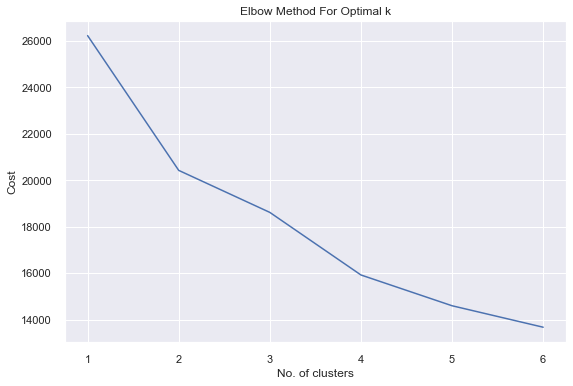

In [91]:
# Elbow curve to find optimal K
cost = []
K = range(1,7)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=0, random_state = 31)
    kmode.fit_predict(kmeans_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [92]:
kmode = KModes(n_clusters=3, init = "random", n_init = 5, verbose=0, random_state = 31)
clusters7 = kmode.fit_predict(kmeans_df)

In [93]:
kmeans_df.insert(0, "Cluster", clusters7, True)
kmeans_df.head()

,Cluster,Ship type,Scoring
0,2,Bulk carrier,3.0
1,2,Bulk carrier,3.0
2,0,Bulk carrier,2.0
3,2,Bulk carrier,3.0
4,0,Bulk carrier,2.0


In [94]:
kmeans_df.groupby('Cluster')['Ship type'].count()

Cluster
0    9747
1    3038
2    5992
Name: Ship type, dtype: int64

In [95]:
kmeans_df.head()

,Cluster,Ship type,Scoring
0,2,Bulk carrier,3.0
1,2,Bulk carrier,3.0
2,0,Bulk carrier,2.0
3,2,Bulk carrier,3.0
4,0,Bulk carrier,2.0


<AxesSubplot:xlabel='Cluster', ylabel='Scoring'>

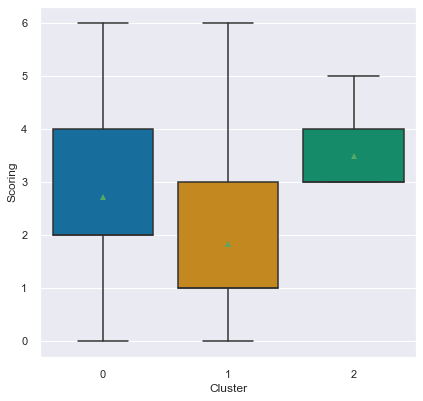

In [96]:
plt.figure(figsize=(6,6))
sns.set(font_scale = 1)
sns.boxplot(y = 'Scoring', x = 'Cluster', data = kmeans_df, palette="colorblind", showfliers = False, showmeans = True)

In [97]:
kmeans_df.groupby(['Cluster', 'Ship type']).describe()

Scoring                                     \
                                     count      mean       std  min  25%  50%   
Cluster Ship type                                                               
0       Bulk carrier                1445.0  2.000000  0.000000  2.0  2.0  2.0   
        Chemical tanker             1317.0  3.129081  1.480382  0.0  2.0  2.0   
        Combination carrier            6.0  3.166667  1.329160  2.0  2.0  3.0   
        Container ship              2979.0  2.723397  1.338594  0.0  2.0  3.0   
        Container/ro-ro cargo ship     1.0  2.000000       NaN  2.0  2.0  2.0   
        Gas carrier                  287.0  2.742160  1.380331  0.0  2.0  2.0   
        General cargo ship           459.0  2.000000  0.000000  2.0  2.0  2.0   
        Oil tanker                  2091.0  3.077475  1.461704  0.0  2.0  2.0   
        Other ship types              62.0  2.629032  1.393590  0.0  2.0  2.0   
        Passenger ship                73.0  2.643836  1.337181  0.0  2.0  2.0   
        Refrigerated cargo carrier   125.0  2.696000  1.357322  0.0  2.0  2.0   
        Ro-pax ship                  306.0  2.702614  1.386040  0.0  2.0  2.0   
        Ro-ro ship                   200.0  2.785000  1.385051  0.0  2.0  2.0   
        Vehicle carrier              396.0  2.618687  1.381085  0.0  2.0  2.0   
1       Bulk carrier                 719.0  1.000000  0.000000  1.0  1.0  1.0   
        Chemical tanker              263.0  1.000000  0.000000  1.0  1.0  1.0   
        Combination carrier            2.0  1.000000  0.000000  1.0  1.0  1.0   
        Gas carrier                   80.0  1.000000  0.000000  1.0  1.0  1.0   
        General cargo ship          1188.0  3.095118  1.483482  0.0  3.0  3.0   
        Oil tanker                   456.0  1.000000  0.000000  1.0  1.0  1.0   
        Other ship types              17.0  1.000000  0.000000  1.0  1.0  1.0   
        Passenger ship                17.0  1.000000  0.000000  1.0  1.0  1.0   
        Refrigerated cargo carrier    33.0  1.000000  0.000000  1.0  1.0  1.0   
        Ro-pax ship                   89.0  1.000000  0.000000  1.0  1.0  1.0   
        Ro-ro ship                    53.0  1.000000  0.000000  1.0  1.0  1.0   
        Vehicle carrier              121.0  1.000000  0.000000  1.0  1.0  1.0   
2       Bulk carrier                3944.0  3.734787  1.166854  0.0  3.0  4.0   
        Chemical tanker              531.0  3.000000  0.000000  3.0  3.0  3.0   
        Combination carrier            5.0  3.000000  0.000000  3.0  3.0  3.0   
        Container/ro-ro cargo ship     3.0  3.000000  0.000000  3.0  3.0  3.0   
        Gas carrier                  115.0  3.000000  0.000000  3.0  3.0  3.0   
        LNG carrier                    2.0  3.000000  0.000000  3.0  3.0  3.0   
        Oil tanker                   883.0  3.000000  0.000000  3.0  3.0  3.0   
        Other ship types              32.0  3.000000  0.000000  3.0  3.0  3.0   
        Passenger ship                32.0  3.000000  0.000000  3.0  3.0  3.0   
        Refrigerated cargo carrier    56.0  3.000000  0.000000  3.0  3.0  3.0   
        Ro-pax ship                  129.0  3.000000  0.000000  3.0  3.0  3.0   
        Ro-ro ship                    95.0  3.000000  0.000000  3.0  3.0  3.0   
        Vehicle carrier              165.0  3.000000  0.000000  3.0  3.0  3.0   

                                              
                                    75%  max  
Cluster Ship type                             
0       Bulk carrier                2.0  2.0  
        Chemical tanker             4.0  6.0  
        Combination carrier         4.0  5.0  
        Container ship              4.0  6.0  
        Container/ro-ro cargo ship  2.0  2.0  
        Gas carrier                 4.0  6.0  
        General cargo ship          2.0  2.0  
        Oil tanker                  4.0  6.0  
        Other ship types            4.0  6.0  
        Passenger ship              4.0  6.0  
        Refrigerated 

In [98]:
df2 = kmeans_df.reset_index().groupby(['Cluster', 'Ship type']).size().to_frame('count')
df2['percentage'] = df2['count'].div(df2.groupby('Ship type')['count'].transform('sum')).mul(100)
df2

count  percentage
Cluster Ship type                                    
0       Bulk carrier                 1445   23.657498
        Chemical tanker              1317   62.387494
        Combination carrier             6   46.153846
        Container ship               2979  100.000000
        Container/ro-ro cargo ship      1   25.000000
        Gas carrier                   287   59.543568
        General cargo ship            459   27.868852
        Oil tanker                   2091   60.962099
        Other ship types               62   55.855856
        Passenger ship                 73   59.836066
        Refrigerated cargo carrier    125   58.411215
        Ro-pax ship                   306   58.396947
        Ro-ro ship                    200   57.471264
        Vehicle carrier               396   58.064516
1       Bulk carrier                  719   11.771447
        Chemical tanker               263   12.458550
        Combination carrier             2   15.384615
        Gas carrier                    80   16.597510
        General cargo ship           1188   72.131148
        Oil tanker                    456   13.294461
        Other ship types               17   15.315315
        Passenger ship                 17   13.934426
        Refrigerated cargo carrier     33   15.420561
        Ro-pax ship                    89   16.984733
        Ro-ro ship                     53   15.229885
        Vehicle carrier               121   17.741935
2       Bulk carrier                 3944   64.571054
        Chemical tanker               531   25.153955
        Combination carrier             5   38.461538
        Container/ro-ro cargo ship      3   75.000000
        Gas carrier                   115   23.858921
        LNG carrier                     2  100.000000
        Oil tanker                    883   25.743440
        Other ship types               32   28.828829
        Passenger ship                 32   26.229508
        Refrigerated cargo carrier     56   26.168224
        Ro-pax ship                   129   24.618321
        Ro-ro ship                     95   27.298851
        Vehicle carrier               165   24.193548

In [99]:
# majority of ships in each cluster
df2[df2['percentage'] > 80]

,,count,percentage
Cluster,Ship type,,
0,Container ship,2979,100.0
2,LNG carrier,2,100.0


# Using cluster = 2


In [100]:
kmeans_df2 = final1.iloc[:,[0,-2]]
kmeans_df2.head()

,Ship type,Scoring
0,Bulk carrier,3.0
1,Bulk carrier,3.0
2,Bulk carrier,2.0
3,Bulk carrier,3.0
4,Bulk carrier,2.0


In [101]:
kmode = KModes(n_clusters=2, init = "random", n_init = 5, verbose=0, random_state = 31)
clusters8 = kmode.fit_predict(kmeans_df2)

In [102]:
kmeans_df2.insert(0, "Cluster", clusters8, True)
kmeans_df2.head()

,Cluster,Ship type,Scoring
0,1,Bulk carrier,3.0
1,1,Bulk carrier,3.0
2,0,Bulk carrier,2.0
3,1,Bulk carrier,3.0
4,0,Bulk carrier,2.0


In [103]:
kmeans_df2.groupby('Cluster')['Ship type'].count()

Cluster
0    11792
1     6985
Name: Ship type, dtype: int64

<AxesSubplot:xlabel='Cluster', ylabel='Scoring'>

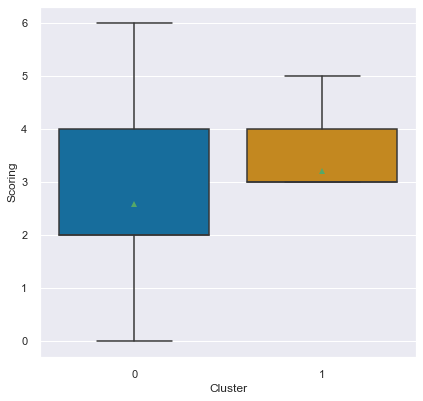

In [104]:
plt.figure(figsize=(6,6))
sns.set(font_scale = 1)
sns.boxplot(y = 'Scoring', x = 'Cluster', data = kmeans_df2, palette="colorblind", showfliers = False, showmeans = True)

In [105]:
kmeans_df2.groupby(['Cluster', 'Ship type']).describe()

Scoring                                 \
                                     count      mean       std  min   25%   
Cluster Ship type                                                           
0       Bulk carrier                1445.0  2.000000  0.000000  2.0  2.00   
        Chemical tanker             1580.0  2.774684  1.567115  0.0  2.00   
        Combination carrier            8.0  2.625000  1.505941  1.0  1.75   
        Container ship              2237.0  2.631650  1.533828  0.0  2.00   
        Container/ro-ro cargo ship     1.0  2.000000       NaN  2.0  2.00   
        Gas carrier                  367.0  2.362398  1.416917  0.0  1.00   
        General cargo ship          1232.0  2.719156  1.557151  0.0  2.00   
        Oil tanker                  3430.0  2.781341  1.337919  0.0  2.00   
        Other ship types              79.0  2.278481  1.404541  0.0  1.00   
        Passenger ship                90.0  2.333333  1.365712  0.0  2.00   
        Refrigerated cargo carrier   158.0  2.341772  1.390469  0.0  1.00   
        Ro-pax ship                  395.0  2.318987  1.412245  0.0  1.00   
        Ro-ro ship                   253.0  2.411067  1.429909  0.0  1.00   
        Vehicle carrier              517.0  2.239845  1.389509  0.0  1.00   
1       Bulk carrier                4663.0  3.313103  1.458482  0.0  3.00   
        Chemical tanker              531.0  3.000000  0.000000  3.0  3.00   
        Combination carrier            5.0  3.000000  0.000000  3.0  3.00   
        Container ship               742.0  3.000000  0.000000  3.0  3.00   
        Container/ro-ro cargo ship     3.0  3.000000  0.000000  3.0  3.00   
        Gas carrier                  115.0  3.000000  0.000000  3.0  3.00   
        General cargo ship           415.0  3.000000  0.000000  3.0  3.00   
        LNG carrier                    2.0  3.000000  0.000000  3.0  3.00   
        Other ship types              32.0  3.000000  0.000000  3.0  3.00   
        Passenger ship                32.0  3.000000  0.000000  3.0  3.00   
        Refrigerated cargo carrier    56.0  3.000000  0.000000  3.0  3.00   
        Ro-pax ship                  129.0  3.000000  0.000000  3.0  3.00   
        Ro-ro ship                    95.0  3.000000  0.000000  3.0  3.00   
        Vehicle carrier              165.0  3.000000  0.000000  3.0  3.00   

                                                   
                                    50%  75%  max  
Cluster Ship type                                  
0       Bulk carrier                2.0  2.0  2.0  
        Chemical tanker             2.0  4.0  6.0  
        Combination carrier         2.0  4.0  5.0  
        Container ship              2.0  4.0  6.0  
        Container/ro-ro cargo ship  2.0  2.0  2.0  
        Gas carrier                 2.0  4.0  6.0  
        General cargo ship          2.0  4.0  6.0  
        Oil tanker                  3.0  4.0  6.0  
        Other ship types            2.0  4.0  6.0  
        Passenger ship              2.0  4.0  6.0  
        Refrigerated cargo carrier  2.0  4.0  6.0  
        Ro-pax ship                 2.0  4.0  6.0  
        Ro-ro ship                  2.0  4.0  6.0  
        Vehicle carrier             2.0  2.0  6.0  
1       Bulk carrier                3.0  4.0  6.0  
        Chemical tanker             3.0  3.0  3.0  
        Combination carrier         3.0  3.0  3.0  
        Container ship              3.0  3.0  3.0  
        Container/ro-ro cargo ship  3.0  3.0  3.0  
        Gas carrier                 3.0  3.0  3.0  
        General cargo ship          3.0  3.0  3.0  
        LNG carrier                 3.0  3.0  3.0  
        Other ship types            3.0  3.0  3.0  
        Passenger ship              3.0  3.0  3.0  
        Refrigerated cargo carrier  3.0  3.0  3.0  
        Ro-pax ship                 3.0  3.0  3.0  
        Ro-ro ship                  3.0  3.0  3.0  
        Vehicle carrier             3.0  3.0  3.0

In [106]:
df3 = kmeans_df2.reset_index().groupby(['Cluster', 'Ship type']).size().to_frame('count')
df3['percentage'] = df3['count'].div(df3.groupby('Ship type')['count'].transform('sum')).mul(100)
df3

count  percentage
Cluster Ship type                                    
0       Bulk carrier                 1445   23.657498
        Chemical tanker              1580   74.846045
        Combination carrier             8   61.538462
        Container ship               2237   75.092313
        Container/ro-ro cargo ship      1   25.000000
        Gas carrier                   367   76.141079
        General cargo ship           1232   74.802672
        Oil tanker                   3430  100.000000
        Other ship types               79   71.171171
        Passenger ship                 90   73.770492
        Refrigerated cargo carrier    158   73.831776
        Ro-pax ship                   395   75.381679
        Ro-ro ship                    253   72.701149
        Vehicle carrier               517   75.806452
1       Bulk carrier                 4663   76.342502
        Chemical tanker               531   25.153955
        Combination carrier             5   38.461538
        Container ship                742   24.907687
        Container/ro-ro cargo ship      3   75.000000
        Gas carrier                   115   23.858921
        General cargo ship            415   25.197328
        LNG carrier                     2  100.000000
        Other ship types               32   28.828829
        Passenger ship                 32   26.229508
        Refrigerated cargo carrier     56   26.168224
        Ro-pax ship                   129   24.618321
        Ro-ro ship                     95   27.298851
        Vehicle carrier               165   24.193548

# KNN

In [107]:
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [108]:
knn_df = final1.iloc[:,[0,1,2,3,-1]]
knn_df.head()

,Ship type,tech_eff,C02 emissions per hour,EEOI_Index,Comparative_scoring
0,Bulk carrier,4.61,2.603082,7.66,average
1,Bulk carrier,5.25,3.972896,6.85,average
2,Bulk carrier,7.18,2.570063,14.41,below average
3,Bulk carrier,5.20,1.832036,14.12,average
4,Bulk carrier,7.48,2.453803,11.25,below average


In [109]:
#creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers
knn_df['ship_type_encoded'] = le.fit_transform(knn_df['Ship type'])
knn_df['comparative_scoring_encoded'] = le.fit_transform(knn_df['Comparative_scoring'])

knn_df.head()

,Ship type,tech_eff,C02 emissions per hour,EEOI_Index,Comparative_scoring,ship_type_encoded,comparative_scoring_encoded
0,Bulk carrier,4.61,2.603082,7.66,average,0,1
1,Bulk carrier,5.25,3.972896,6.85,average,0,1
2,Bulk carrier,7.18,2.570063,14.41,below average,0,2
3,Bulk carrier,5.20,1.832036,14.12,average,0,1
4,Bulk carrier,7.48,2.453803,11.25,below average,0,2


In [110]:
len(knn_df['comparative_scoring_encoded'])

18777

In [111]:
knn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18777 entries, 0 to 681
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Ship type                    18777 non-null  object 
 1   tech_eff                     18777 non-null  float64
 2   C02 emissions per hour       18777 non-null  float64
 3   EEOI_Index                   18777 non-null  float64
 4   Comparative_scoring          18777 non-null  object 
 5   ship_type_encoded            18777 non-null  int64  
 6   comparative_scoring_encoded  18777 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


In [112]:
# numerical values for the different ship types - for example, 'Bulk carrier' is encoded with '0'
knn_df.groupby(['Ship type', 'ship_type_encoded']).tech_eff.count()

Ship type                   ship_type_encoded
Bulk carrier                0                    6108
Chemical tanker             1                    2111
Combination carrier         2                      13
Container ship              3                    2979
Container/ro-ro cargo ship  4                       4
Gas carrier                 5                     482
General cargo ship          6                    1647
LNG carrier                 7                       2
Oil tanker                  8                    3430
Other ship types            9                     111
Passenger ship              10                    122
Refrigerated cargo carrier  11                    214
Ro-pax ship                 12                    524
Ro-ro ship                  13                    348
Vehicle carrier             14                    682
Name: tech_eff, dtype: int64

In [113]:
knn_df2= knn_df.iloc[:,[1,2,3,5,6]]
knn_df2.head()

,tech_eff,C02 emissions per hour,EEOI_Index,ship_type_encoded,comparative_scoring_encoded
0,4.61,2.603082,7.66,0,1
1,5.25,3.972896,6.85,0,1
2,7.18,2.570063,14.41,0,2
3,5.20,1.832036,14.12,0,1
4,7.48,2.453803,11.25,0,2


In [114]:
knn_df2.describe()

,tech_eff,C02 emissions per hour,EEOI_Index,ship_type_encoded,comparative_scoring_encoded
count,18777.000000,18777.000000,18777.000000,18777.000000,18777.000000
mean,9.876830,4.155114,33.346971,4.035203,1.134580
std,7.093782,2.763931,96.263418,4.187752,0.855224
min,2.870000,0.857816,3.560000,0.000000,0.000000
25%,4.630000,2.581823,8.440000,0.000000,0.000000
50%,6.680000,3.327522,12.750000,3.000000,1.000000
75%,14.000000,4.595558,23.690000,8.000000,2.000000
max,65.760000,21.353963,2038.890000,14.000000,2.000000


In [115]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(knn_df2, knn_df2['comparative_scoring_encoded'], 
                                                    test_size=0.3, random_state = 31) # 70% training and 30% test

In [116]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [117]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8814341498047569
